In [4]:
import os
import sys

# From notebooks/ go one level up to the project root (where src/ and config.py live)
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

print("Project root:", project_root)
print("src in root?", os.path.isdir(os.path.join(project_root, "src")))
print("config in root?", os.path.isfile(os.path.join(project_root, "config.py")))


Project root: c:\Users\XiliWangMainSkyAsset\OneDrive - MainSky\Dokumente\Codes\FI
src in root? True
config in root? True


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from config import (
    FILE_PATH_INPUTS,
    HMM_FEATURE_COLS,
    MACRO_COLS,
    ASSETS,
    BARBELL_WEIGHTS,
    TC_STRUCTURAL,
    TC_BARBELL,
    CRISIS_WINDOWS,
)
from src.data_loader import (
    load_macro_data,
    load_asset_prices,
    prepare_asset_returns,
)
from src.regime_model import estimate_regimes
from src.factor_engine import (
    build_macro_panel,
    align_macro_with_regimes,
    compute_macro_state_means,
    compute_risk_signals,
)
from src.allocation_model import (
    compute_regime_asset_stats,
    construct_regime_portfolios,
    mix_regime_portfolios_over_time,
    build_final_allocation,
)
from src.backtester import backtest_with_rebal, compute_turnover
from src.metrics import perf_stats, window_stats


In [6]:
data = load_macro_data(FILE_PATH_INPUTS)
prices = load_asset_prices(FILE_PATH_INPUTS)
asset_returns = prepare_asset_returns(prices, ASSETS)

print("Macro panel shape:", data.shape)
print("Asset returns shape:", asset_returns.shape)


Macro panel shape: (1355, 20)
Asset returns shape: (309, 6)


c:\Users\XiliWangMainSkyAsset\OneDrive - MainSky\Dokumente\Codes\FI\src\data_loader.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data.set_index("Date").asfreq("M")
c:\Users\XiliWangMainSkyAsset\OneDrive - MainSky\Dokumente\Codes\FI\src\data_loader.py:43: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  prices = prices.resample("M").last()


In [7]:
regime_result = estimate_regimes(
    data=data,
    feature_cols=HMM_FEATURE_COLS,
    span=3,
    n_components_list=(2, 3, 4),
    random_state=42,
)

post_smooth = regime_result["posteriors_smooth"]
state_mapping = regime_result["state_mapping"]

print("State mapping:")
for state_name, label in state_mapping.items():
    print(f"  {state_name}: {label}")


State mapping:
  State 0: Carry-Friendly
  State 3: Volatility Transition
  State 1: Defensive
  State 2: Capital-Protection Mode


In [8]:
state_cols = [c for c in post_smooth.columns if c.startswith("State_")]
panel = asset_returns.join(post_smooth[state_cols], how="inner")

R = panel[ASSETS]
P = post_smooth[state_cols].loc[panel.index]

print("Aligned returns shape:", R.shape)
print("Aligned posteriors shape:", P.shape)

state_means, state_covs = compute_regime_asset_stats(R, P, ASSETS)
print("State means shape:", state_means.shape)
print("State covariances shape:", state_covs.shape)


Aligned returns shape: (309, 6)
Aligned posteriors shape: (309, 4)
State means shape: (4, 6)
State covariances shape: (4, 6, 6)


In [9]:
state_weights = construct_regime_portfolios(
    state_means=state_means,
    state_covs=state_covs,
    state_mapping=state_mapping,
)

labels = [state_mapping[f"State {k}"] for k in range(state_weights.shape[0])]
state_weights_df = pd.DataFrame(state_weights, index=labels, columns=ASSETS)

print("\nStructural regime portfolios (per regime, sum to 1):")
print(state_weights_df.round(3))

W_base = mix_regime_portfolios_over_time(
    state_weights=state_weights,
    posteriors=P,
    index=panel.index,
    assets=ASSETS,
)

print("\nBase regime-mix weights (first 5 rows):")
print(W_base.head())



Structural regime portfolios (per regime, sum to 1):
                         Rates_10Y  Bills_3M  IG_Credit  HY_Credit  \
Carry-Friendly               0.324     0.324      0.027      0.162   
Defensive                    0.286     0.286      0.143      0.143   
Capital-Protection Mode      0.286     0.286      0.143      0.143   
Volatility Transition        0.324     0.324      0.027      0.162   

                         Infl_Linked  Tail_Hedge  
Carry-Friendly                 0.162       0.000  
Defensive                      0.143       0.000  
Capital-Protection Mode        0.000       0.143  
Volatility Transition          0.000       0.162  

Base regime-mix weights (first 5 rows):
            Rates_10Y  Bills_3M  IG_Credit  HY_Credit  Infl_Linked  \
Date                                                                 
2000-02-29   0.285715  0.285715   0.142856   0.142857     0.142856   
2000-03-31   0.285714  0.285714   0.142857   0.142857     0.142857   
2000-04-30   0.2857

In [10]:
macro_panel = build_macro_panel(data, MACRO_COLS)
macro_panel_aligned, post_smooth_macro = align_macro_with_regimes(
    macro_panel,
    post_smooth,
)

risk_signals = compute_risk_signals(
    macro_panel=macro_panel_aligned,
    panel_index=panel.index,
)

print("\nRisk signals (head):")
print(risk_signals.head())

W_final = build_final_allocation(
    W_base=W_base,
    posteriors=P,
    risk_signals=risk_signals,
    state_mapping=state_mapping,
    assets=ASSETS,
)

print("\nFinal allocation (head):")
print(W_final.head())



Risk signals (head):
            infl_risk  growth_risk  policy_risk  geo_risk  combo_risk  \
Date                                                                    
2000-02-29        0.0     0.563804     0.242365  1.726732    0.984549   
2000-03-31        0.0     0.563804     0.242365  1.726732    0.984549   
2000-04-30        0.0     0.563804     0.242365  1.726732    0.984549   
2000-05-31        0.0     0.563804     0.242365  1.726732    0.984549   
2000-06-30        0.0     0.563804     0.242365  1.726732    0.984549   

               z_EPU     z_GPR  
Date                            
2000-02-29  0.242365  1.726732  
2000-03-31  0.242365  1.726732  
2000-04-30  0.242365  1.726732  
2000-05-31  0.242365  1.726732  
2000-06-30  0.242365  1.726732  

Final allocation (head):
            Rates_10Y  Bills_3M  IG_Credit  HY_Credit  Infl_Linked  Tail_Hedge
Date                                                                          
2000-02-29   0.203067  0.400772   0.107768    0.085

In [11]:
r_struct = backtest_with_rebal(
    target_weights_df=W_final,
    returns_df=R,
    tc=TC_STRUCTURAL,
)

barbell_targets = pd.DataFrame(
    np.tile(BARBELL_WEIGHTS / BARBELL_WEIGHTS.sum(), (len(R), 1)),
    index=R.index,
    columns=ASSETS,
)

r_barbell = backtest_with_rebal(
    target_weights_df=barbell_targets,
    returns_df=R,
    tc=TC_BARBELL,
)

stats_struct = perf_stats(r_struct)
stats_barbell = perf_stats(r_barbell)

results = pd.DataFrame(
    [stats_struct, stats_barbell],
    index=["Regime_structural_macro", "Static_barbell"],
)

print("\nBacktest performance (annualised, log-return based):")
print(results)



Backtest performance (annualised, log-return based):
                         Ann. Return  Ann. Vol    Sharpe  Max Drawdown
Regime_structural_macro     0.046303  0.038028  1.217623     -0.102671
Static_barbell              0.040355  0.037793  1.067812     -0.117899


In [12]:
rows = []
for name, (start, end) in CRISIS_WINDOWS.items():
    rows.append(window_stats(r_struct, start, end, f"{name}_Regime"))
    rows.append(window_stats(r_barbell, start, end, f"{name}_Barbell"))

crisis_df = pd.DataFrame(rows)
print("\nCrisis window stats:")
print(crisis_df)



Crisis window stats:
                   Label       Start         End  CumReturn     MaxDD
0   GFC_2007_2009_Regime  2007-07-01  2009-06-30   0.127952 -0.071935
1  GFC_2007_2009_Barbell  2007-07-01  2009-06-30   0.126377 -0.055631
2      COVID_2020_Regime  2020-02-01  2020-12-31   0.056778 -0.013922
3     COVID_2020_Barbell  2020-02-01  2020-12-31   0.051998 -0.011221


In [13]:
avg_turnover_monthly, avg_turnover_annual = compute_turnover(W_final)

print("\nTurnover statistics:")
print(f"  Avg monthly turnover: {avg_turnover_monthly:.4f}")
print(f"  Approx annual turnover: {avg_turnover_annual:.4f}")



Turnover statistics:
  Avg monthly turnover: 0.0164
  Approx annual turnover: 0.1966


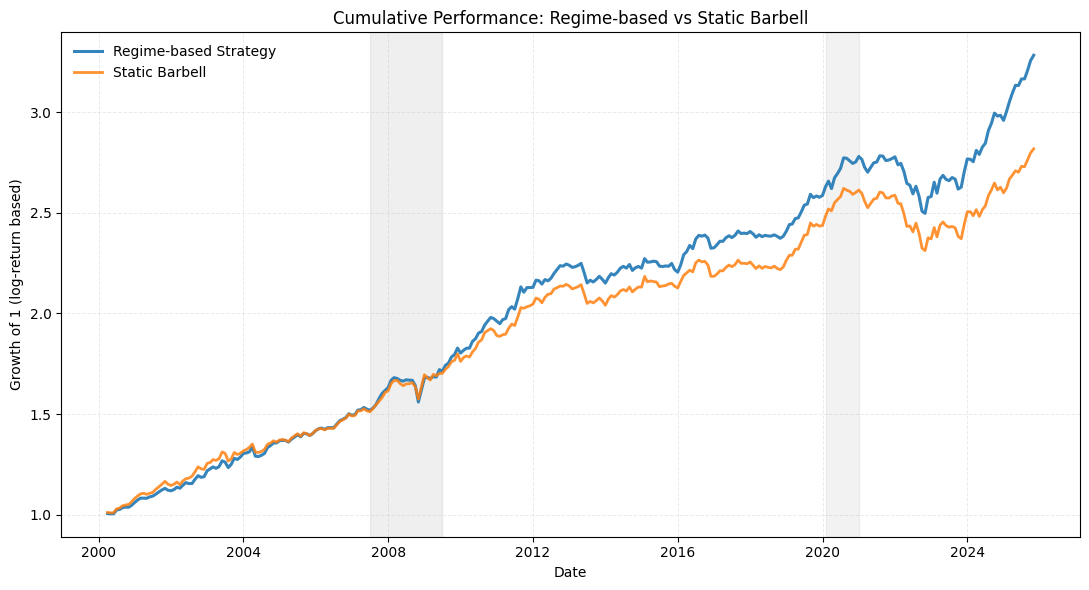

In [14]:
cum_struct = np.exp(r_struct.cumsum())
cum_barbell = np.exp(r_barbell.cumsum())

cum_panel = pd.DataFrame(
    {
        "Regime_structural_macro": cum_struct,
        "Static_barbell": cum_barbell,
    }
)

plt.figure(figsize=(11, 6))

plt.plot(
    cum_panel["Regime_structural_macro"],
    label="Regime-based Strategy",
    linewidth=2.2,
    alpha=0.9,
)

plt.plot(
    cum_panel["Static_barbell"],
    label="Static Barbell",
    linewidth=2.0,
    alpha=0.85,
)

plt.axvspan(pd.to_datetime("2007-07-01"), pd.to_datetime("2009-06-30"),
            color="grey", alpha=0.12)
plt.axvspan(pd.to_datetime("2020-02-01"), pd.to_datetime("2020-12-31"),
            color="grey", alpha=0.10)

plt.title("Cumulative Performance: Regime-based vs Static Barbell")
plt.ylabel("Growth of 1 (log-return based)")
plt.xlabel("Date")
plt.grid(alpha=0.25, linestyle="--", linewidth=0.7)
plt.legend(frameon=False, loc="upper left")
plt.tight_layout()
plt.show()
